# MSD distribution

This script is used to calculate the distribution of Mean Squared Displacement for Single Molecule tracks.

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
# Get data
def dataIN(filename):
    return pd.read_csv(filename)

In [184]:
# Calculate time from frames
def calc_time(data, interval=0.022):
    data['TIME'] = data.FRAME * interval
    return data

In [185]:
# Calculate lifetime for each track
def calc_lifetime(data):
    data["LIFETIME"] = data.groupby("TRACK_ID")["FRAME"].transform(lambda x: x - x.min())
    return data

In [186]:
# Calculate MSD for each time window
def calc_MSD(data, time_interval = 0.022):
    # Maximum lifetime
    max_lifetime = data.LIFETIME.max()
    
    # Array of step sizes from 1 to the largest lifetime
    step_size = np.arange(1, max_lifetime)
    
    all_steps = np.empty(0)         # store steps where MSD was calculated
    all_msds = np.empty(0)          # store MSD
    all_counts = np.empty(0)        # store number of events from which MSD was calculated

    # Iterate through different step sizes
    for step in step_size:
        # Break points of tracks with specific step size
        breaks = np.arange(0, max_lifetime+1, step)[1:]
        # Initiate array to store squared displacements
        all_sq_disp = np.empty(0)

        # Iterate through different break points
        for brk in breaks:
            # Calculate the sum of squared displacements for broken tracks
            # Makes sure tracks fall within breakpoints and end at the breakpoint
            sq_disp = data.loc[
                (data.LIFETIME >= brk-step) &
                (data.LIFETIME <= brk), :]\
                .groupby("TRACK_ID")[["TRACK_ID", "LIFETIME", "SQ_DISP"]]\
                .filter(lambda x: x["LIFETIME"].max() == step)\
                .groupby("TRACK_ID")["SQ_DISP"]\
                .aggregate(lambda x: x.sum())
            
            # Store the sum of squared displacements for all breakpoints with the current step size
            all_sq_disp = np.concatenate((all_sq_disp, np.array(sq_disp)), axis = 0)

        # Count number of tracks in current step size
        ncount = len(all_sq_disp)

        # Continue if no tracks with current step size found
        if ncount == 0:
            continue
        
        # Calculate MSD at current step size
        msd = all_sq_disp.mean()
        
        # Store step size, MSD and counts
        all_steps = np.append(all_steps, step)
        all_msds = np.append(all_msds, msd)
        all_counts = np.append(all_counts, ncount)

        # Show progress
        if step%100 == 0:
            print(f"Step: {step:5}/{max_lifetime}, MSD: {msd:5.2f}, NCOUNT: {ncount:6}")
        
    # Generate dataframe for MSD data
    msd_data = pd.DataFrame(
        {
            'Step' : all_steps,
            'Time' : all_steps * time_interval,
            'Count' : all_counts,
            'MSD' : all_msds
        }
    )

    return msd_data

In [187]:
# Plot data
def plotData(msd_data, outname, save=True):

    # Restrict x-axis to data with greater than equal to 30 counts in MSD determination
    xlimit = round(msd_data.loc[msd_data.Count >= 30, :].Time.max(), 1)

    # Plot parameters
    plot = sns.relplot(
        data=msd_data,
        x="Time",
        y="MSD",
        kind="scatter",
        linewidth=0,
        hue="Count",
        hue_norm=(0, 100)
    )
    plot.set_xlabels(u"Time [s]")
    plot.set_ylabels(u"Mean squared displacement [µm$^2$]")
    # plot.set(xlim=(0, xlimit), ylim=(0, 15))
    plot.set(xlim=(0, 5), ylim=(0, 15))
    plot.figure.suptitle(' '.join(outname.split('_')))
    plot._legend.remove()
    
    # Save and/or show plot
    if save:
        outname = f'{outname}_MSDplot.png'
        plt.show()
        plot.savefig(f"{outname}", dpi=300)
    else:
        plt.show()

In [188]:
# Write data
def dataOUT(msd_data, outname):
    outname = f'{outname}_MSD-data.csv'
    msd_data.to_csv(outname, index = False)

In [189]:
# Main function
def main():
    filename = "1xGBD_Outside_A_stepsize-data.csv"      # input file name
    outname = '_'.join(filename.split('_')[:3])         # output file name prefix
    data = dataIN(filename)                             # get data
    data = calc_time(data)                              # calculate time
    data = calc_lifetime(data)                          # calculate lifetime
    msd_data = calc_MSD(data)                           # calculated MSDs
    plotData(msd_data, outname)                         # plot data
    dataOUT(msd_data, outname)                          # write MSD data

Step:   100/865, MSD:  4.39, NCOUNT:    319
Step:   200/865, MSD:  8.76, NCOUNT:     52
Step:   300/865, MSD: 11.61, NCOUNT:     14
Step:   400/865, MSD: 13.18, NCOUNT:      2
Step:   500/865, MSD: 14.02, NCOUNT:      2
Step:   600/865, MSD: 15.61, NCOUNT:      2
Step:   700/865, MSD: 14.25, NCOUNT:      1
Step:   800/865, MSD: 16.76, NCOUNT:      1


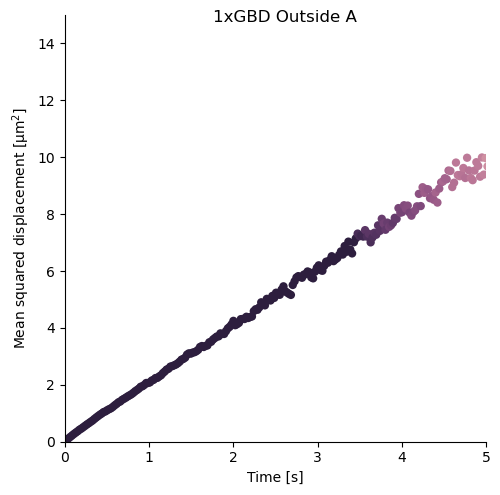

In [190]:
# Run main
main()

> Ankit Roy

> 25th March, 2024